# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [ ]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [ ]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
      return (np.linalg.norm(X @ w - y)**2) / len(X)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 / len(X) * (X.T @ (X @ w - y))

In [ ]:
# Проведем небольшую проверку реализации

# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    history = []
    history.append(w_init)
    w = w_init

    for i in range(n_iterations):
      w_new = w - lr * loss.calc_grad(X, y, w)
      history.append(w_new)
      w = w_new

    return history

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045025
0.8670644395649494


In [ ]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(10, 10))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

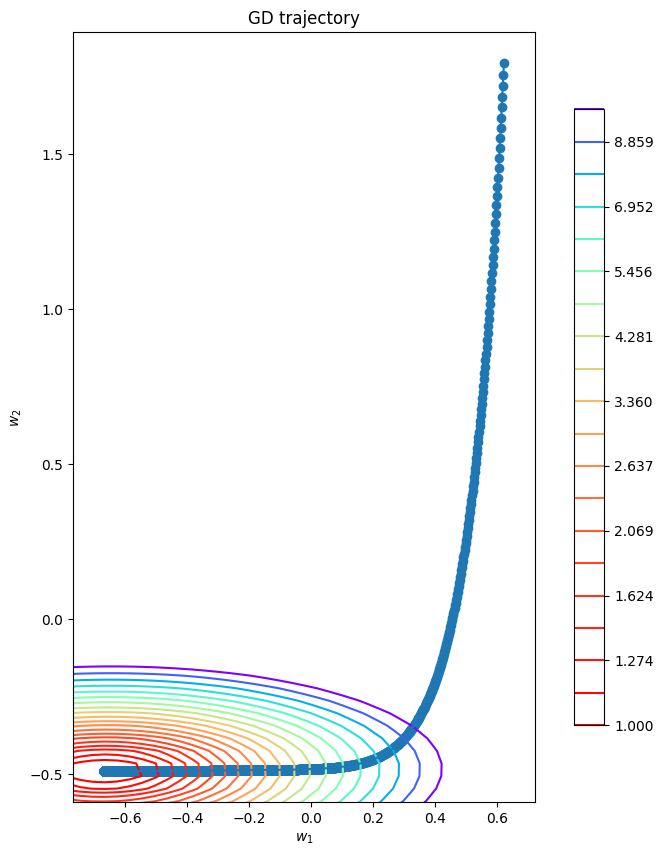

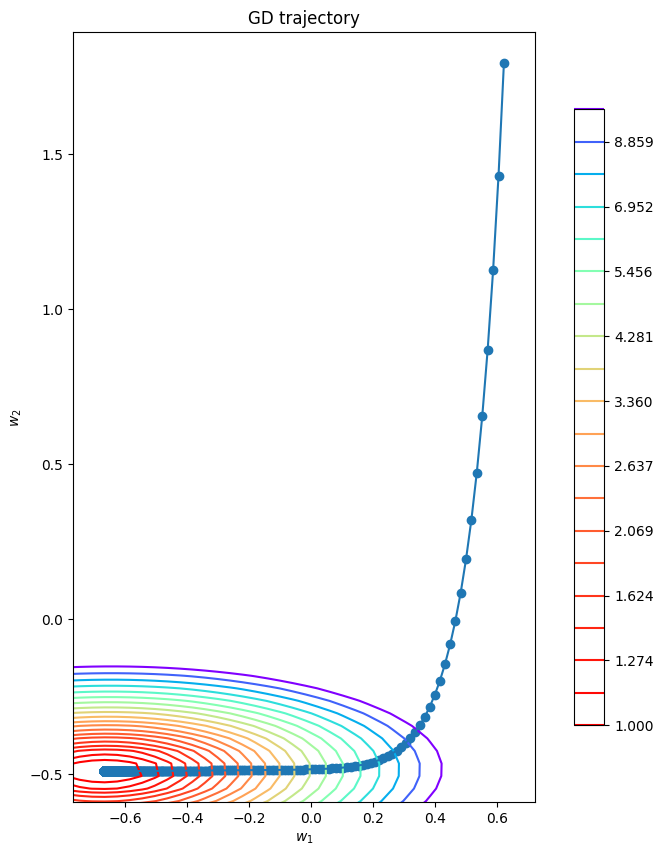

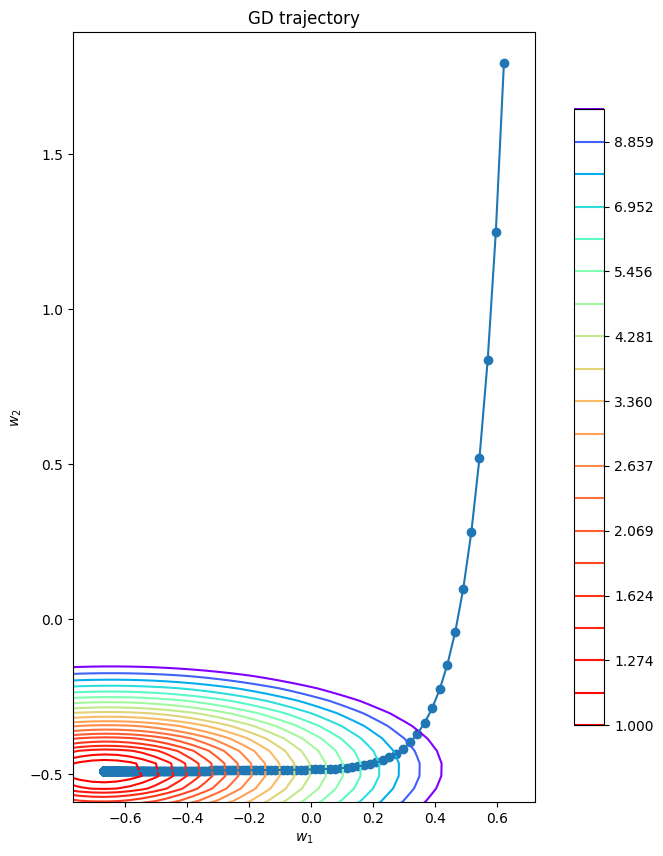

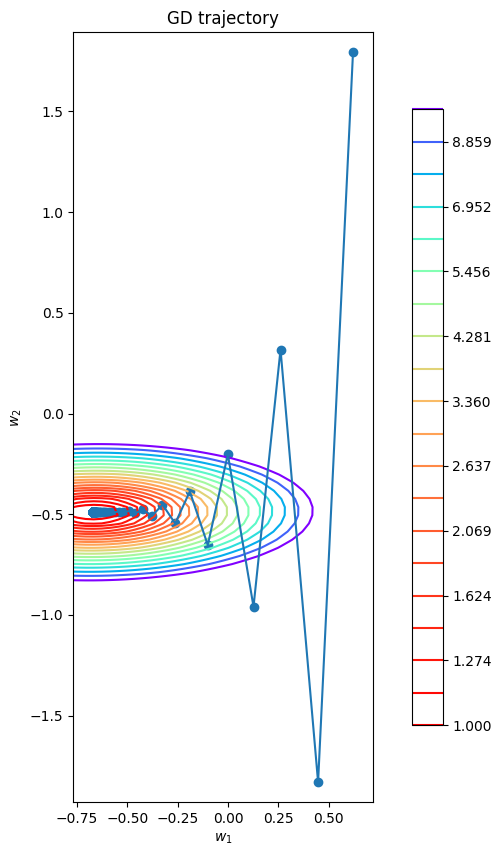

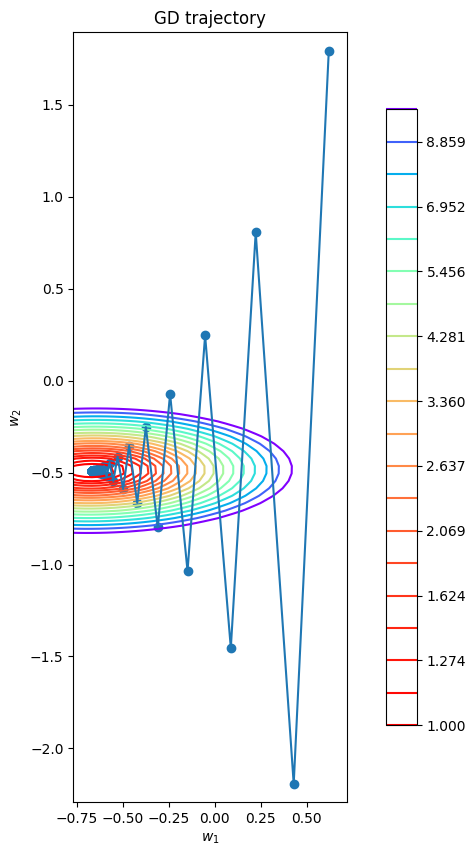

In [ ]:
lr_list = [0.0001, 0.001, 0.0015, 0.01, 0.011]

for lr in lr_list:
  w_list = gradient_descent(w_init, X, y, loss, lr, 100000)
  plot_gd(w_list, X, y, loss)

**Вывод:**
Чем больше параметр lr, тем больший шаг будет сделан в сторону антиградиента. Если lr слишком маленький, то спуск будет происходить маленькими шагами, и при малом количестве итераций можно не дойти до минимума. Если же шаги слишком большие, то можно уйти на бесконечность.

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    history = []
    history.append(w_init)
    w = w_init

    for i in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]

      w_new = w - lr * loss.calc_grad(X_batch, y_batch, w)
      history.append(w_new)
      w = w_new

    return history

При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

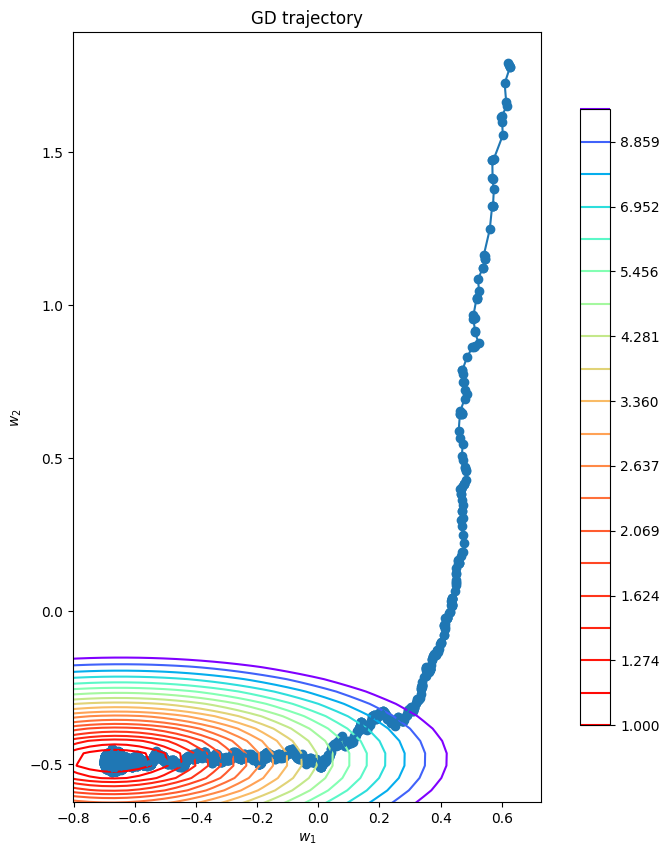

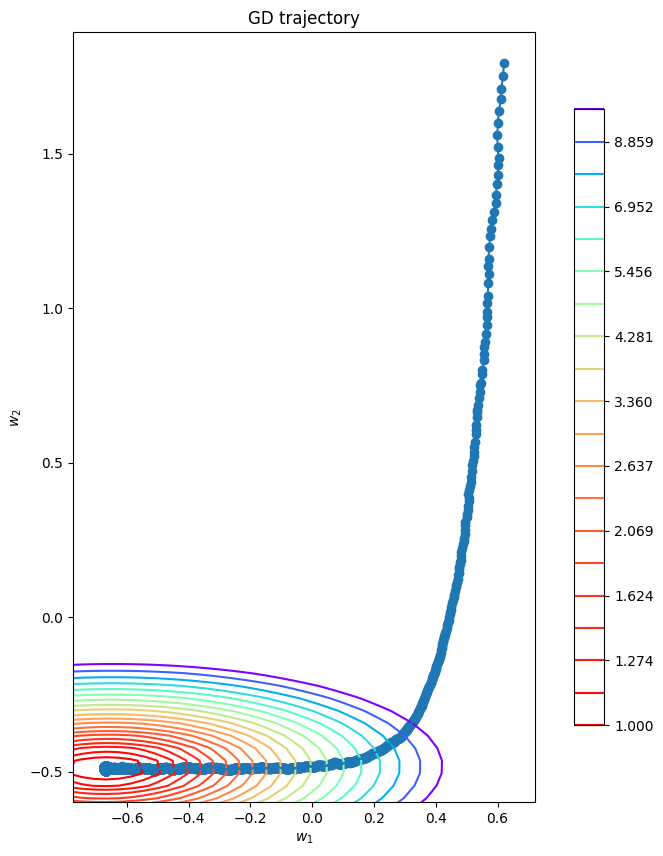

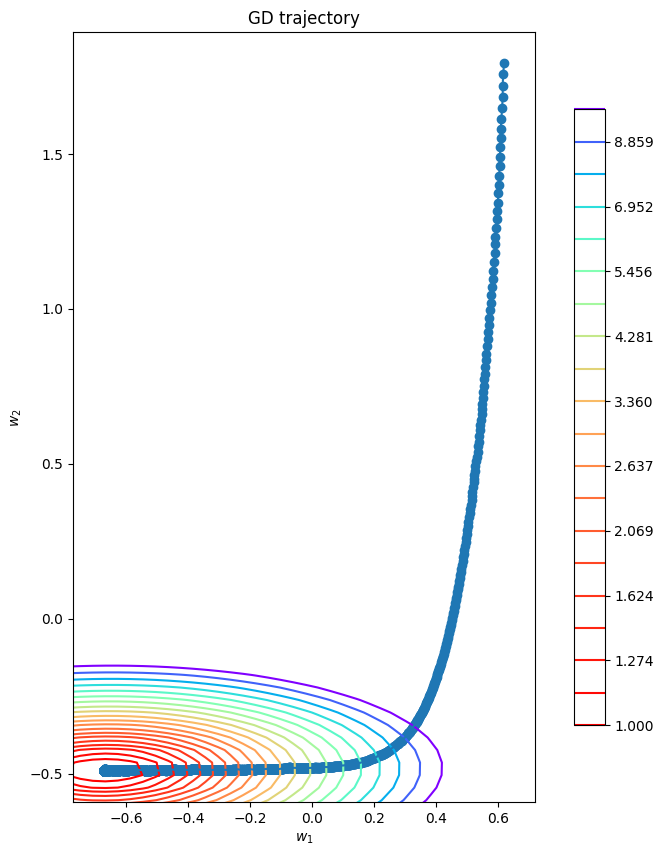

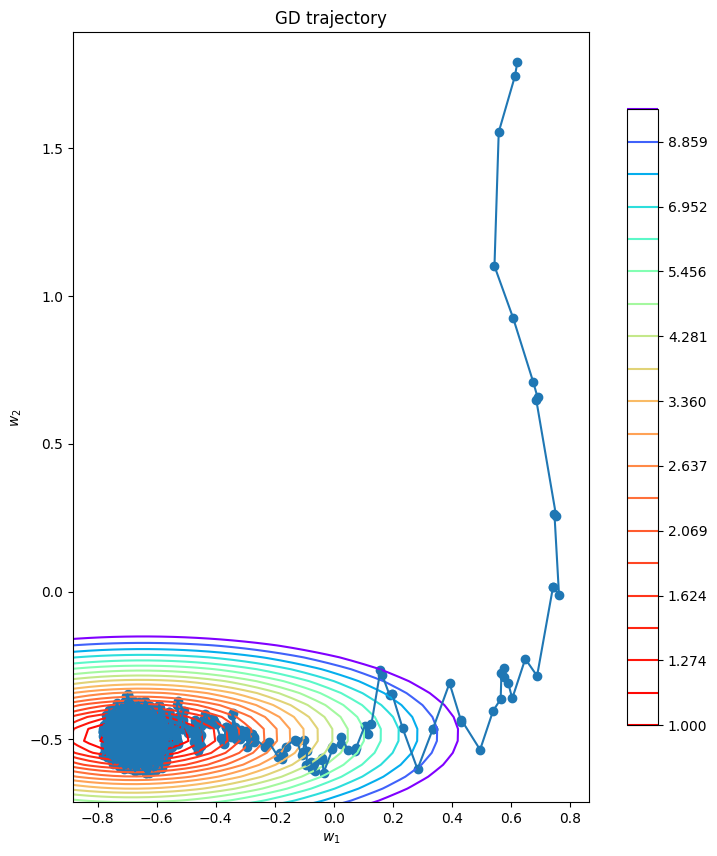

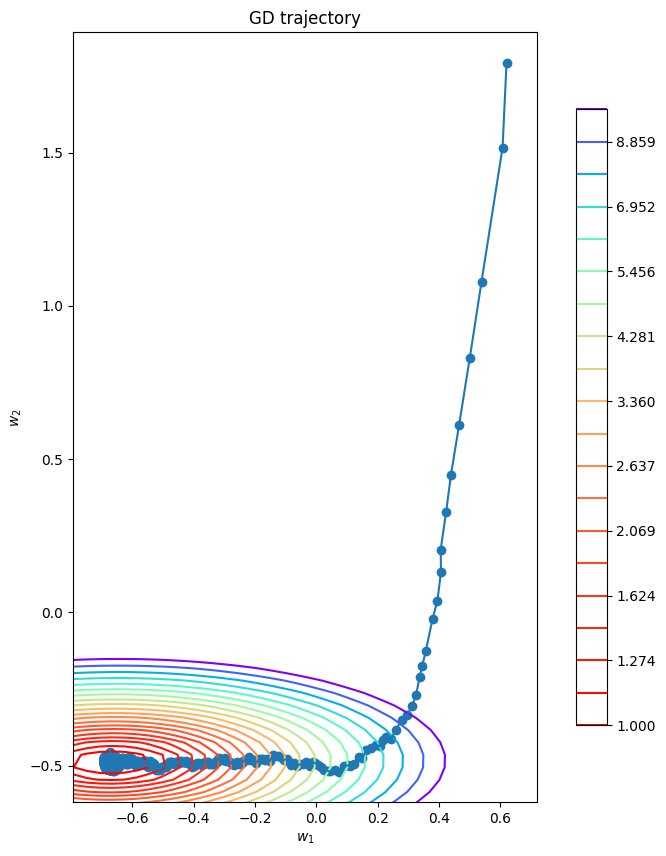

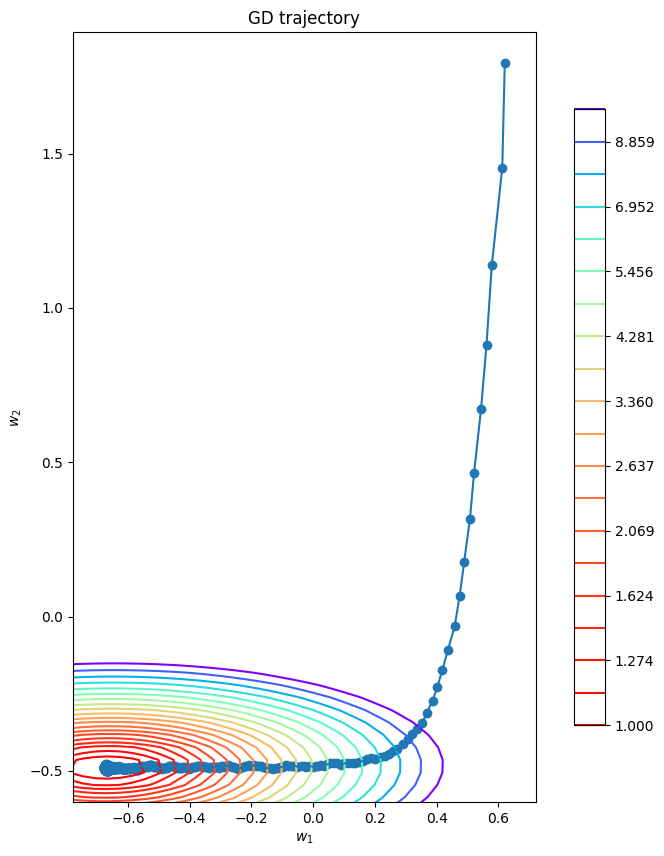

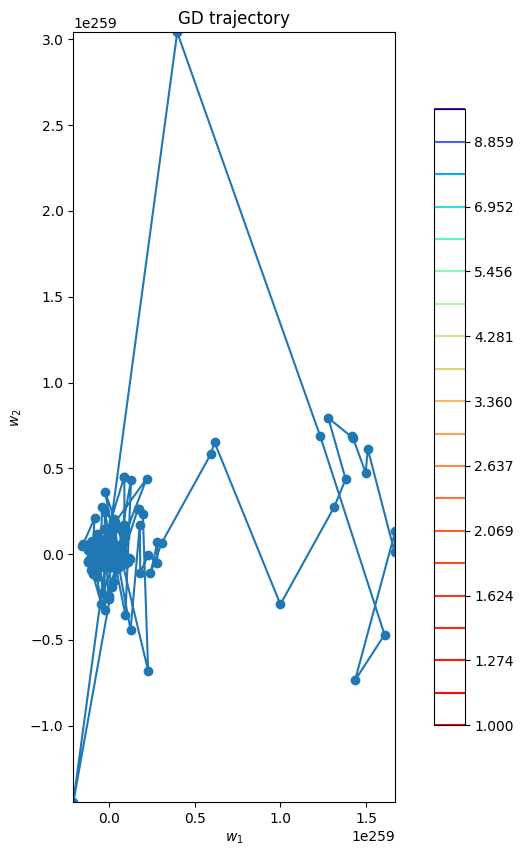

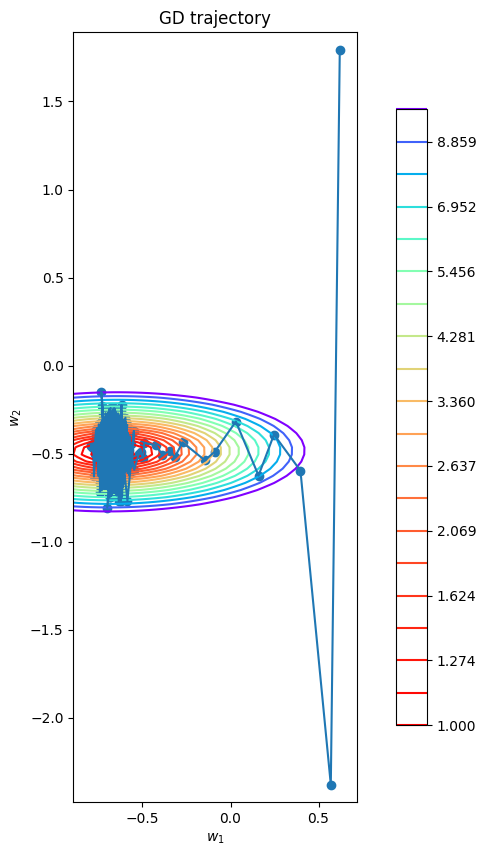

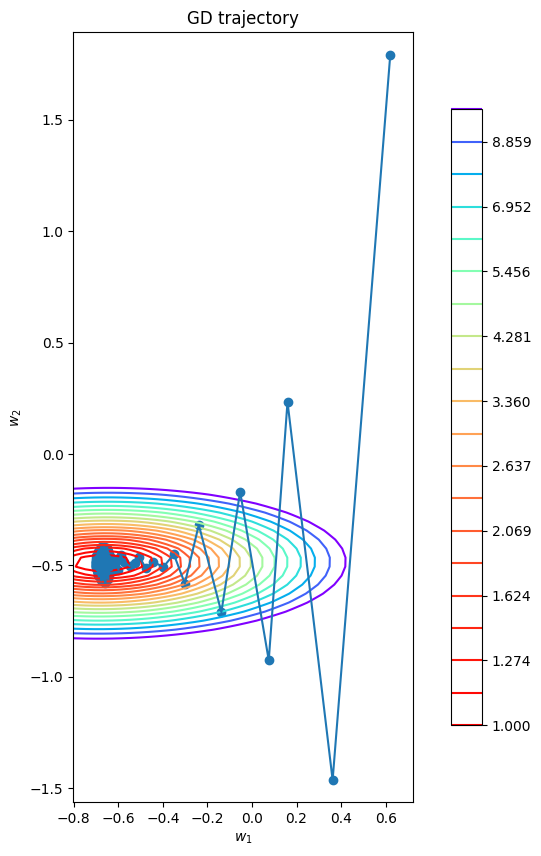

In [ ]:
lr_list = [0.0001, 0.001, 0.01]
batch_list = [1, 20, 100]

for lr in lr_list:
  for batch_size in batch_list:
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, 100000)
    plot_gd(w_list, X, y, loss)

**Вывод:**

Видно, что при при маленьком lr график градиентного спуска наиболее гладкий при большом размере батчей, при этом во всех 3 случаях можно дойти до локального минимума. Для среднего lr наименьший разброс также при большом размере батчей. При большом lr в случае с единичным батчем до локального минимума дойти не удается (шаги слишком большие и направления слишком хаотичные), с чуть большим размером батчей заметны проблемы с попаданием в минимум вблизи минимума.

Можно сделать вывод, что при небольшом размере батчей характер направлений становится более хаотичным. Если к тому же брать достаточно большой lr, то до локального минимума будет не добраться.

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [ ]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """

    history = []
    history.append(w_init)
    w = w_init

    for i in range(n_iterations):
      step = lr * (1 / (1 + i)) ** p

      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]

      w_new = w - step * loss.calc_grad(X_batch, y_batch, w)
      history.append(w_new)
      w = w_new

    return history

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

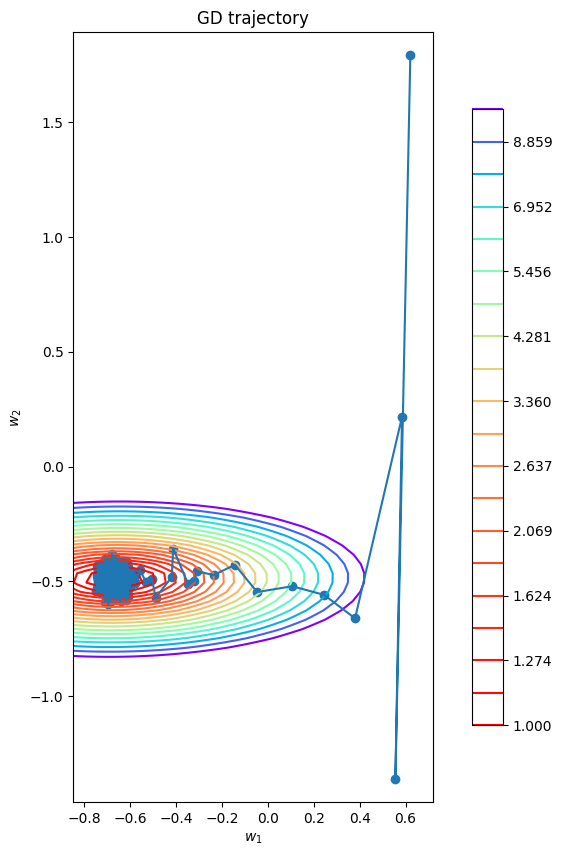

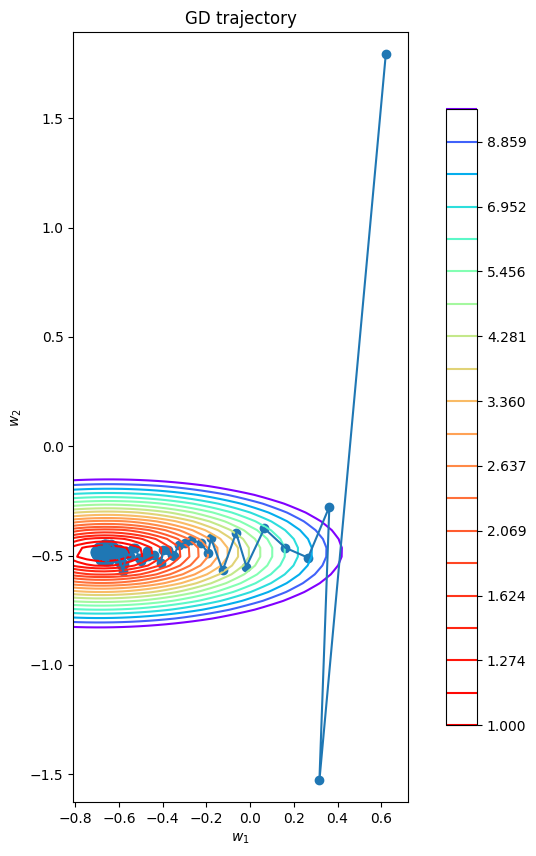

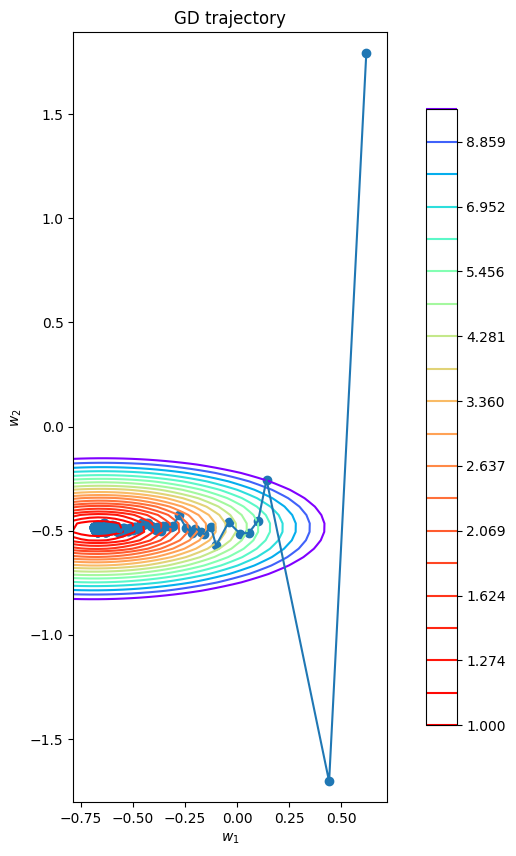

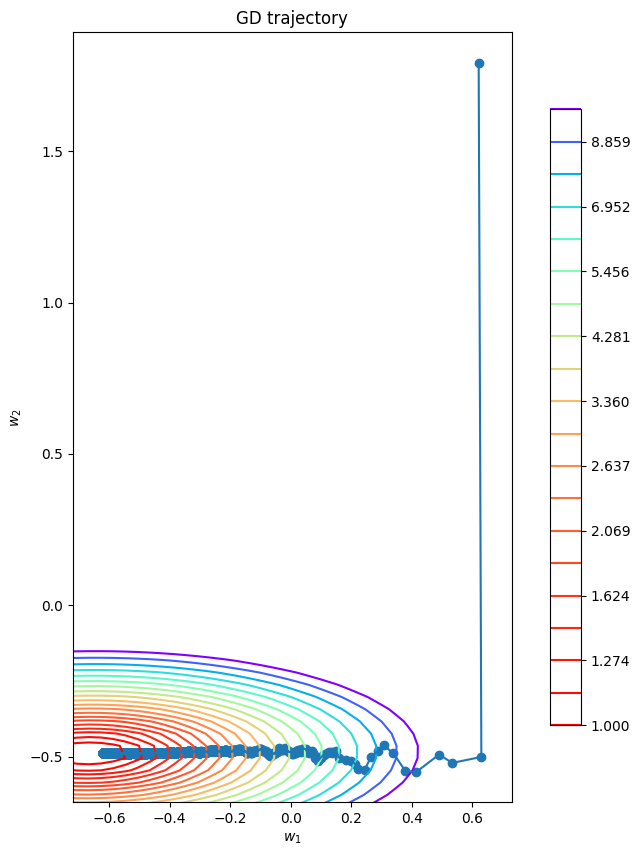

In [ ]:
p_list = [0.1, 0.3, 0.5, 0.9]

for p in p_list:
    w_list = stochastic_gradient_descent_with_decay(w_init, X, y, loss, 0.01, 10, p, 100000)
    plot_gd(w_list, X, y, loss)

**Вывод:**
Чем больше p, тем меньше будет становиться шаг с каждой итерацией. То есть с помощью p можно регулировать степень уменьшения шага с каждой итерацией.

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

<Axes: >

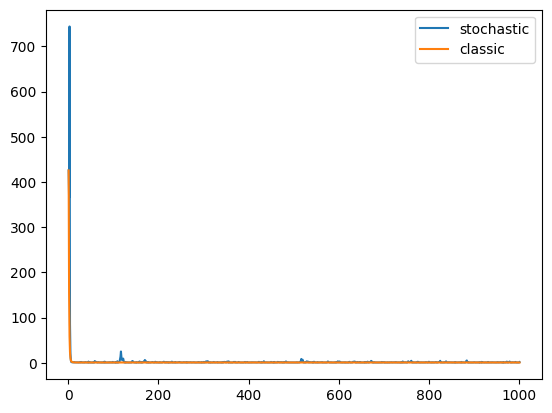

In [ ]:
import seaborn as sns

lr = 0.01
batch_size = 10
n_iters = 1000
w_stoch = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, n_iters)
w_classic = gradient_descent(w_init, X, y, loss, lr, n_iters)
sns.lineplot(x = np.arange(1, n_iters+2), y = list(map(lambda w: loss.calc_loss(X, y, w), w_stoch)), label = "stochastic")
sns.lineplot(x = np.arange(1, n_iters+2), y = list(map(lambda w: loss.calc_loss(X, y, w), w_classic)), label = "classic")

**Ответ**
На данном графике не видно приемуществ SGD, потому что, казалось бы, его шаги более шумные. Но вычислять их гораздо быстрее, то есть можно прийти к разумному результату (найти минимум) с меньшими потерями ресурсов - в этом и есть приемущество SGD.

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)

        X_with_ones = np.c_[np.ones(X.shape[0]), X]
        w_init = np.random.uniform(-2, 2, (X_with_ones.shape[1]))

        self.w = gradient_descent(w_init, X_with_ones, y, self.loss, self.lr)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"

        X_with_ones = np.c_[np.ones(X.shape[0]), X]
        return X_with_ones @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index(drop=True)
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size = 0.2)

numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

train_mean = numeric_data.mean()

X_train[numeric_features] = X_train[numeric_features].fillna(train_mean)
X_test[numeric_features] = X_test[numeric_features].fillna(train_mean)

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna('NotGiven')
X_test[categorical] = X_test[categorical].fillna('NotGiven')

column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

Обучите линейную регрессию на обучающей выборке

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(MSELoss()))])
model = pipeline.fit(X_train, y_train)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [ ]:
def r2(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    sum1 = np.sum((y_true - y_predicted) ** 2)
    sum2 = np.sum((y_true - np.mean(y_true)) ** 2)

    return 1 - (sum1 / sum2)

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [ ]:
y_pred_train_mse = model.predict(X_train)
y_pred_test_mse = model.predict(X_test)

print("r2 for MSE train = %.4f" % r2(y_train, y_pred_train_mse))
print("r2 for MSE test = %.4f" % r2(y_test, y_pred_test_mse))

r2 for MSE train = 0.9746
r2 for MSE test = 0.9019


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: Нет, не надо, поскольку он является константой и влияет разве что на сдвиг предсказаний по вертикали.

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        reg = self.coef * (np.linalg.norm(w[1:])) ** 2
        return (np.linalg.norm(X @ w - y) ** 2) / len(X) + reg

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        w[0] = 0
        return 2 / len(X) * (X.T @ (X @ w - y)) + 2 * self.coef * w

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [ ]:
l2_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(MSEL2Loss(0.1)))])
model = l2_pipeline.fit(X_train, y_train)

y_pred_train_l2 = model.predict(X_train)
y_pred_test_l2 = model.predict(X_test)

print("r2 for MSEL2 train = %.4f" % r2(y_train, y_pred_train_l2))
print("r2 for MSEL2 test = %.4f" % r2(y_test, y_pred_test_l2))

r2 for MSEL2 train = 0.8878
r2 for MSEL2 test = 0.7937


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
coefs = []
for coef in np.linspace(0.0001, 0.001, 5):
  l2_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(MSEL2Loss(coef)))])
  l2_pipeline.fit(X_train, y_train)
  prediction = l2_pipeline.predict(X_val)
  coefs.append((coef, r2(y_val, prediction)))
best_coef = max(coefs, key = lambda x: x[1])

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

In [ ]:
best_coef

(np.float64(0.001), np.float64(0.8603004148225428))

In [ ]:
l2_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(MSEL2Loss(best_coef[0])))])
l2_pipeline.fit(X_train, y_train)
y_pred_test_l2_best = l2_pipeline.predict(X_test)
print("r2 for MSEL2 train with best_coef = %.4f" %r2(y_test, y_pred_test_l2_best))

r2 for MSEL2 train with best_coef = 0.9188


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        prediction = X @ w
        deviation = prediction - y
        return np.mean(np.vectorize(self.fi)(deviation))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        prediction = X @ w
        deviation = prediction - y
        return (X.T @ np.vectorize(self.grad_fi)(deviation)) / len(X)

    def fi(self, z: float) -> float:
        if -self.eps < z < self.eps:
          return 0.5 * z ** 2
        return self.eps * (np.abs(z) - 0.5 * self.eps)

    def grad_fi(self, z: float) -> float:
        if -self.eps < z < self.eps:
          return z
        return self.eps * np.sign(z)

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [ ]:
hl_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(HuberLoss(4000), 0.001))])
model = hl_pipeline.fit(X_train, y_train)

y_pred_train_hl = model.predict(X_train)
y_pred_test_hl = model.predict(X_test)

print("r2 for HuberLoss train = %.4f" % r2(y_train, y_pred_train_hl))
print("r2 for HuberLoss test = %.4f" % r2(y_test, y_pred_test_hl))

r2 for HuberLoss train = 0.9607
r2 for HuberLoss test = 0.9216


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


**Вывод**

In [ ]:
print("r2 for MSE test = %.4f" % r2(y_test, y_pred_test_mse))
print("r2 for MSEL2 test = %.4f" % r2(y_test, y_pred_test_l2))
print("r2 for MSEL2 test with best_coef = %.4f" % r2(y_test, y_pred_test_l2_best))
print("r2 for HuberLoss test = %.4f" % r2(y_test, y_pred_test_hl))

r2 for MSE test = 0.9019
r2 for MSEL2 test = 0.7937
r2 for MSEL2 test with best_coef = 0.9188
r2 for HuberLoss test = 0.9216


Вставьте ваш любимый мем 2025 в ячейку ниже:

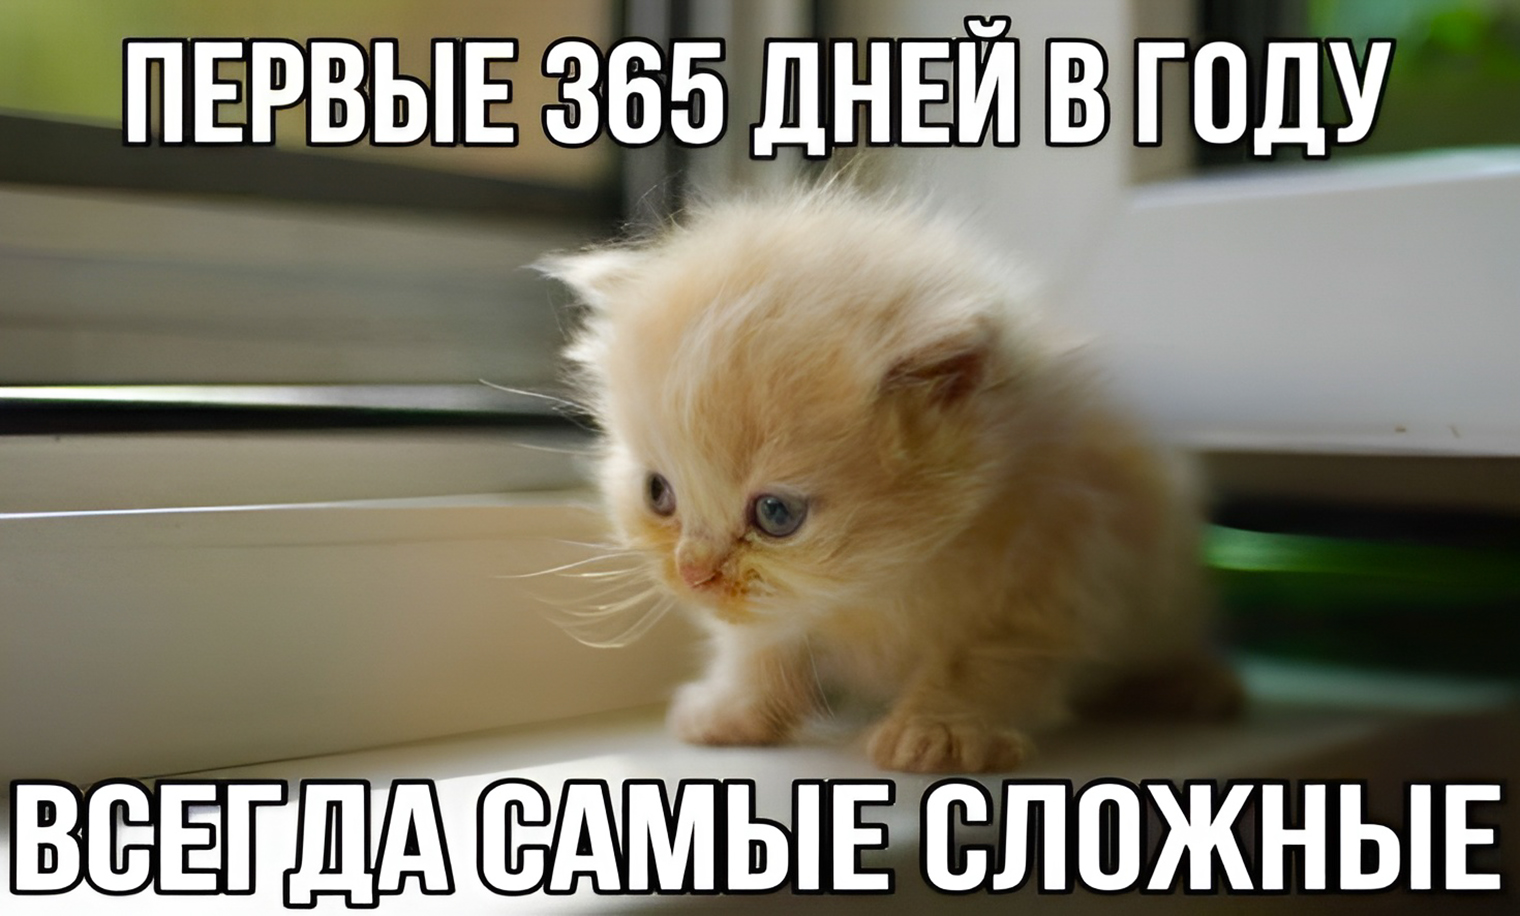